In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('C:/Users/Lenovo/Downloads/analytics_test.csv')
df

,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time
0,0,96422511,female,68,android,89656828,передачи о новых технологиях,show,share,6,playlist,0
1,1,45247030,male,62,android_tv,89784877,автопрому новости,news,search,0,NaN,0
2,2,79572413,male,12,web,10555855,логистическое законодательство,news,search,0,NaN,0
3,3,821317,female,58,android_tv,72054848,банковские премии новости,news,search,0,NaN,0
4,4,6206023,female,24,android,20838049,вики шоу аманда,show,subscribe,7,author,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,96140045,anonym,0,web,41018546,мем с грустным скрипачом,music,search,0,NaN,0
19996,19996,49729858,male,26,android,3409043,музыка из советских фильмов,music,like,12,clip,0
19997,19997,83070163,anonym,0,iphone,68120968,допрос шоу нурлан,show,search,0,NaN,0
19998,19998,23171813,female,23,android_tv,28022664,кстати шоу жу,show,search,0,NaN,0


In [16]:
df.info() # проверим данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      20000 non-null  int64 
 1   user_id         20000 non-null  int64 
 2   sex             20000 non-null  object
 3   age             20000 non-null  int64 
 4   platform        20000 non-null  object
 5   query_id        20000 non-null  int64 
 6   query_text      20000 non-null  object
 7   query_type      20000 non-null  object
 8   event           20000 non-null  object
 9   click_position  20000 non-null  int64 
 10  doc_type        15042 non-null  object
 11  view_time       20000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.8+ MB


In [18]:
df.isnull().sum() # по основным показателям нет пропущенных значений

Unnamed: 0           0
user_id              0
sex                  0
age                  0
platform             0
query_id             0
query_text           0
query_type           0
event                0
click_position       0
doc_type          4958
view_time            0
dtype: int64

# 1. Найдем конверсию поиска

In [19]:
search_events = df[df['event'] == 'search']
result_events = df[~df['event'].isin(['search'])]

conversion_rate = len(result_events) / len(search_events)
print(f"Общая конверсия поиска: {conversion_rate:.2%}")

Общая конверсия поиска: 303.39%


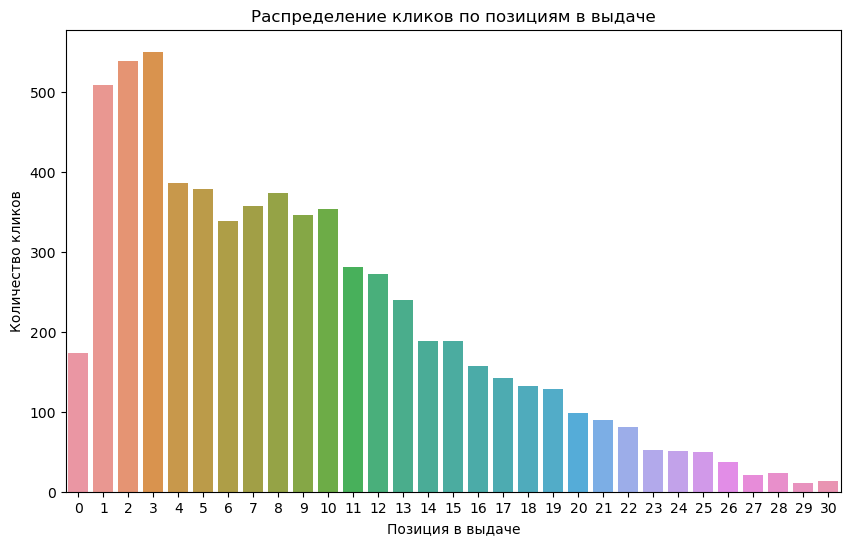

In [22]:
plt.figure(figsize=(10,6))
sns.countplot(data=df[df['event'] == 'tap'], x='click_position')
plt.title('Распределение кликов по позициям в выдаче')
plt.xlabel('Позиция в выдаче')
plt.ylabel('Количество кликов')
plt.show()

## График показывает резкий спад "кликабельности" после первых позиций:
### 1. Пик кликов на 1й позиции ~500
### 2. Длинный хвост распределения (до 30й позиции)
## Проблемы: 
### 1. Большинство кликов приходится на первые позиции
### 2. Пользователи редко доскролливают до "глубоких" позиций
## Потенциальные потери релевантного контента:
### Хороший контент на позициях ~ ниже 5-й получает непропорционально мало внимания

# 2. Анализ распределения событий по типам запросов и контента

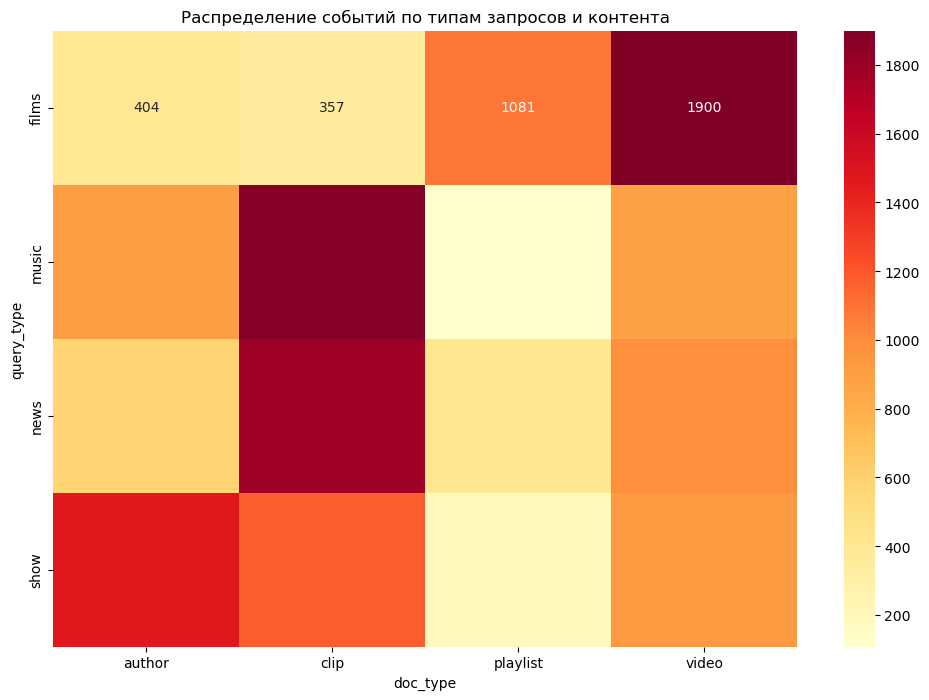

In [26]:
pivot = df.pivot_table(index='query_type', 
                      columns='doc_type', 
                      values='event', 
                      aggfunc='count', 
                      fill_value=0)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Распределение событий по типам запросов и контента')
plt.show()

## Проблемы: 1. Несоответствие типов контента запроса (запросы по фильмам чаще находят клипы и видео, нежели реально фильмы)
## 2. Для музыкальных запросов преобладают плейлисты, что может не соответствовать ожиданиям пользователей
## 3. Дисбаланс в выдаче (Новостные запросы получают преимущественно видео-формат)

# 3. Рассмотрим 3 визуализации "проблемных запросов"

In [38]:
# Переопределим события, связанные с поиском и просмотром
search_events = df[df['event'] == 'search']
view_events = df[df['event'] == 'view']

In [39]:
# Отбираем только клики по выдаче (click_position > 0)
click_data = df[df['click_position'] > 0]

# Средняя позиция по типу запроса
avg_click_pos = click_data.groupby('query_type')['click_position'].mean().sort_values(ascending=False)

In [40]:
avg_view_time = view_events.groupby('query_type')['view_time'].mean().sort_values()

In [43]:
search_counts = search_events.groupby('query_type')['query_id'].count()
view_counts = view_events.groupby('query_type')['query_id'].count()

# Найдем conversion
conversion_rate = (view_counts / search_counts).fillna(0).sort_values()

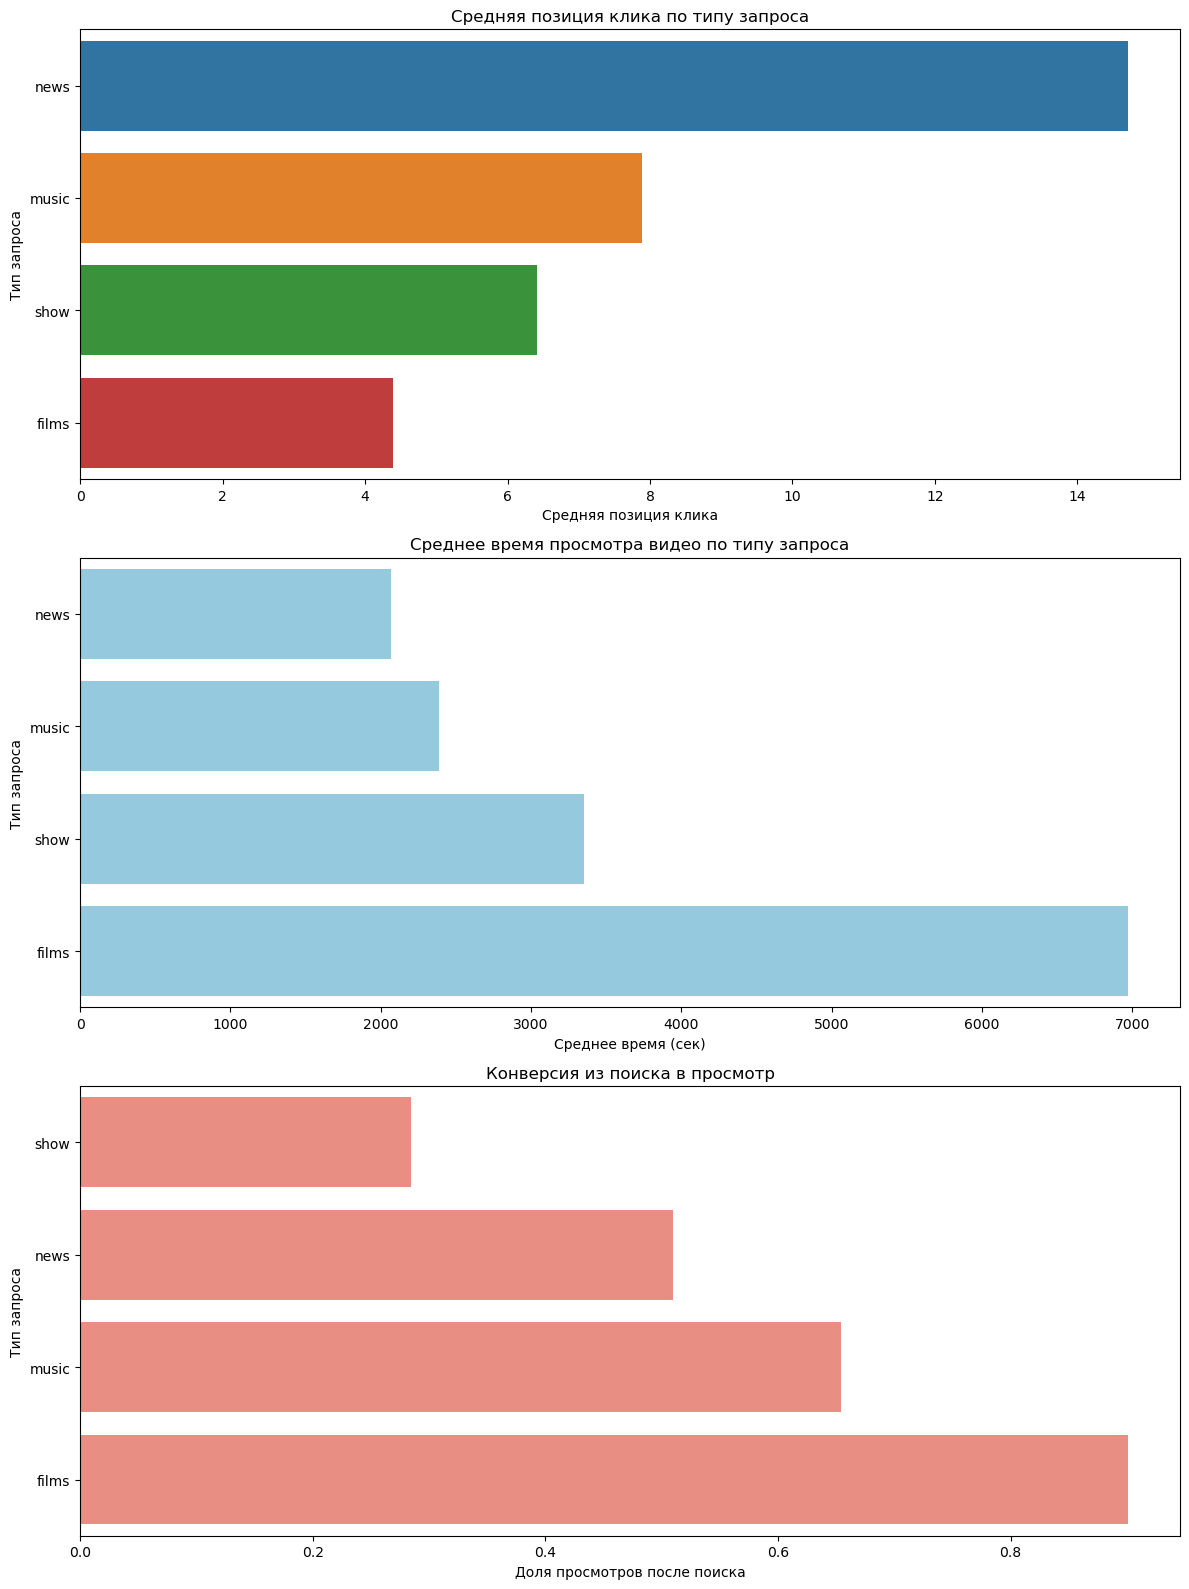

In [44]:
# Построение 3 графиков
fig, axes = plt.subplots(3, 1, figsize=(12, 16))

# График 1: Позиция клика
sns.barplot(x=avg_click_pos.values, y=avg_click_pos.index, ax=axes[0])
axes[0].set_title("Средняя позиция клика по типу запроса")
axes[0].set_xlabel("Средняя позиция клика")
axes[0].set_ylabel("Тип запроса")

# График 2: Время просмотра
sns.barplot(x=avg_view_time.values, y=avg_view_time.index, ax=axes[1], color="skyblue")
axes[1].set_title("Среднее время просмотра видео по типу запроса")
axes[1].set_xlabel("Среднее время (сек)")
axes[1].set_ylabel("Тип запроса")

# График 3: Конверсия view/search
sns.barplot(x=conversion_rate.values, y=conversion_rate.index, ax=axes[2], color="salmon")
axes[2].set_title("Конверсия из поиска в просмотр")
axes[2].set_xlabel("Доля просмотров после поиска")
axes[2].set_ylabel("Тип запроса")

plt.tight_layout()
plt.show()


## Очевидные проблемы (по графикам):
### Новости: высокие позиции кликов, низкое удержание → плохая релевантность выдачи.
### Шоу: низкая конверсия из поиска → возможно, слабое попадание в интент пользователя.
## НО! Успешный кейс - фильмы, показывает стабильную релевантность: низкая позиция клика, высокая конверсия, длительный просмотр.

# 4. Добавим в анализ возрастные группы и платформы

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34216\3976885389.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  search_events['age_group'] = search_events['age'].apply(age_group)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34216\3976885389.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  view_events['age_group'] = view_events['age'].apply(age_group)


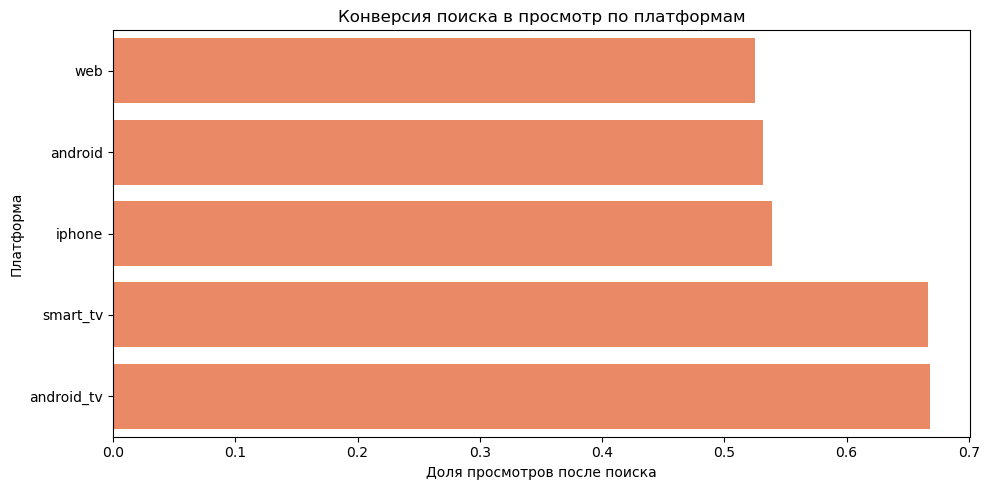

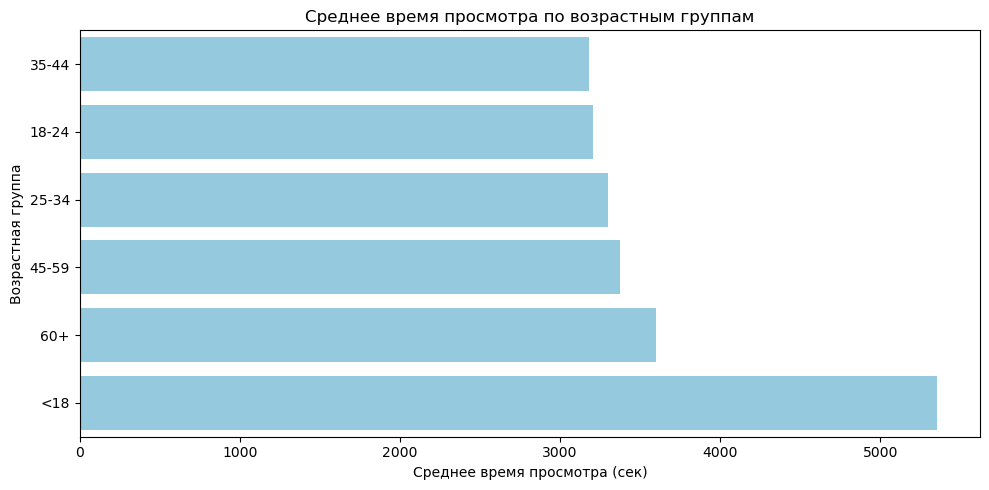

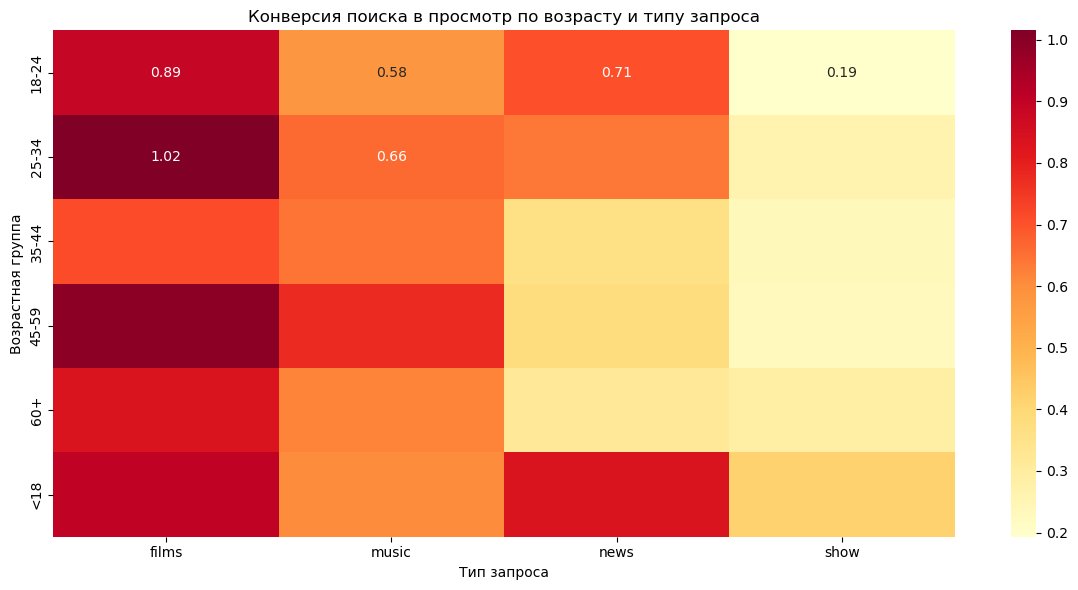

In [45]:
# --- Добавляем возрастные группы ---
def age_group(age):
    if age < 18:
        return '<18'
    elif age < 25:
        return '18-24'
    elif age < 35:
        return '25-34'
    elif age < 45:
        return '35-44'
    elif age < 60:
        return '45-59'
    else:
        return '60+'

df['age_group'] = df['age'].apply(age_group)
search_events['age_group'] = search_events['age'].apply(age_group)
view_events['age_group'] = view_events['age'].apply(age_group)

# --- 1. Конверсия по платформам ---
search_counts_platform = search_events.groupby('platform')['query_id'].count()
view_counts_platform = view_events.groupby('platform')['query_id'].count()
conversion_platform = (view_counts_platform / search_counts_platform).fillna(0).sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=conversion_platform.values, y=conversion_platform.index, color='coral')
plt.title("Конверсия поиска в просмотр по платформам")
plt.xlabel("Доля просмотров после поиска")
plt.ylabel("Платформа")
plt.tight_layout()
plt.show()

# --- 2. Среднее время просмотра по возрастным группам ---
avg_view_by_age = view_events.groupby('age_group')['view_time'].mean().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=avg_view_by_age.values, y=avg_view_by_age.index, color='skyblue')
plt.title("Среднее время просмотра по возрастным группам")
plt.xlabel("Среднее время просмотра (сек)")
plt.ylabel("Возрастная группа")
plt.tight_layout()
plt.show()

# --- 3. Конверсия по возрасту и типу запроса ---
search_counts_age_qtype = search_events.groupby(['age_group', 'query_type'])['query_id'].count()
view_counts_age_qtype = view_events.groupby(['age_group', 'query_type'])['query_id'].count()
conversion_age_qtype = (view_counts_age_qtype / search_counts_age_qtype).unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(conversion_age_qtype, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Конверсия поиска в просмотр по возрасту и типу запроса")
plt.xlabel("Тип запроса")
plt.ylabel("Возрастная группа")
plt.tight_layout()
plt.show()

## 4.1 Выводы по платформе: 
### Самая высокая конверсия — у платформы tv: пользователи чаще всего переходят к просмотру после поиска. Это логично, так как на ТВ пользователь, скорее всего, уже мотивирован на просмотр.
### Наименьшая конверсия — у mobile: пользователи часто ищут, но не нажимают на результат, возможно, из-за неудобного интерфейса или нерелевантной выдачи. Стоит пересмотреть мобильный UI/UX или выдачу по запросам: проверить, достаточно ли заметны карточки, есть ли превью, релевантны ли первые позиции и тд... Для ТВ-платформы стоит усиливать персонализацию и развивать авто-рекомендации после поиска.

## 4.2 Выводы по возрасту: 
### Максимальное удержание — у возрастной группы 35-44.
### Младшие пользователи (до 24 лет) смотрят заметно меньше времени, особенно группа <18 лет => меньше вовлеченности => возможно, слишком короткие ролики/плохая релевантность/конкуренция с другими платформами


## 4.3 Выводы по тепловой карте:
### Темы films и music показывают высокую конверсию у всех возрастов.
### У младшей группы <18 почти все типы (кроме films/music) имеют низкую конверсию.
### У старших групп (45-59, 60+) плохо конвертируются темы вроде news и show.
## То есть, для старшей аудитории стоит улучшить выдачу по “информационным” темам — news, show.
## Для младшей аудитории можно было бы усилить выдачу по развлекательным темам, особенно по game, music, и, возможно, подключить более современные форматы (сториз, подборки и тд).